# Test de rectangularisation fruste

_Jérôme Lacaille_ (20/12/2024)

In [1]:
# Import minimal.

import os
import numpy as np
import pandas as pd
import tabata as tbt
import matplotlib.pyplot as plt
import ipywidgets as widgets
%matplotlib inline



## 1. Renormalisation des données.

In [2]:
# Chargement des données.
datadir = "../Data/cleaned/"
final_file = datadir + "AFL1EB_cleaned_final.h5"
norm_file = datadir + "AFL1EB_normed_alt.h5"
dsc = tbt.Opset(final_file)
dsc

OPSET '../Data/cleaned/AFL1EB_cleaned_final.h5' de 47 signaux.
        position courante : sigpos  = 0
        variable courante : colname = ALT[m]
        phase surlignée   : phase   = None

In [3]:
dsc.plot()

In [4]:
# Ajout d'une référence normalisée à utiliser pour la transformation.

dsn1 = tbt.Opset(norm_file).clean()
for df in dsc:
    alt = df["ALT[m]"]
    max_alt = np.max(alt)
    min_alt = np.min(alt)
    altn = (alt-min_alt)/(max_alt-min_alt)
    df["ALTN[-]"] = altn
    dsn1.put(df)
dsn1

OPSET '../Data/cleaned/AFL1EB_normed_alt.h5' de 47 signaux.
        position courante : sigpos  = 46
        variable courante : colname = ALT[m]
        phase surlignée   : phase   = None

In [6]:
dsn1.plot()

In [7]:
df = dsn1.df
x = df["ALTN[-]"]
x.index

DatetimeIndex(['2013-01-19 20:25:00', '2013-01-19 20:25:01',
               '2013-01-19 20:25:02', '2013-01-19 20:25:03',
               '2013-01-19 20:25:04', '2013-01-19 20:25:05',
               '2013-01-19 20:25:06', '2013-01-19 20:25:07',
               '2013-01-19 20:25:08', '2013-01-19 20:25:09',
               ...
               '2013-01-19 22:21:57', '2013-01-19 22:21:58',
               '2013-01-19 22:21:59', '2013-01-19 22:22:00',
               '2013-01-19 22:22:01', '2013-01-19 22:22:02',
               '2013-01-19 22:22:03', '2013-01-19 22:22:04',
               '2013-01-19 22:22:05', '2013-01-19 22:22:06'],
              dtype='datetime64[ns]', name='record_11', length=7027, freq='s')

In [8]:
df.index.name

'record_11'

In [9]:
t0 = x.index[0].value
t1 = x.index[-1].value
t = pd.to_datetime(np.linspace(t0,t1,50))
y = np.interp(t,x.index,x.values)


len(x)=7027
len(y)=50


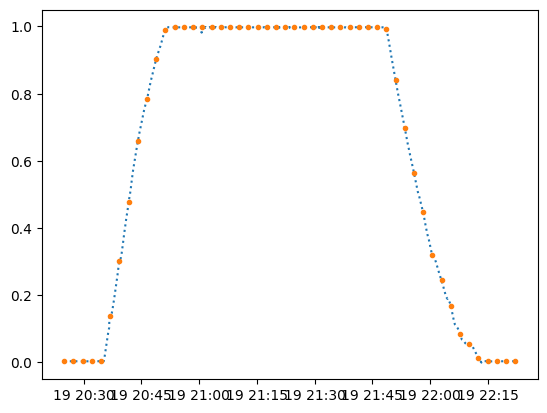

In [10]:
plt.plot(x,':')
plt.plot(t,y,'.')
print(f"len(x)={len(x)}")
print(f"len(y)={len(y)}")

In [11]:
# Création d'une interpolation linéaire.

N = 50 # sélection du nombre de points de mesures.
Y = []
Cols = []
for df in dsn1:
    x = df["ALTN[-]"]
    t0 = x.index[0].value
    t1 = x.index[-1].value
    t = pd.to_datetime(np.linspace(t0,t1,N))
    y = np.interp(t,x.index,x.values)
    Y.append(y)
    Cols.append(df.index.name)
ALT = pd.DataFrame(data=np.vstack(Y).T,columns=Cols)

In [13]:
ALT.tail()

,record_00,record_01,record_02,record_03,record_04,record_05,record_11,record_12,record_13,record_14,...,record_42,record_43,record_44,record_45,record_46,record_47,record_48,record_49,record_50,record_51
45,0.004347,0.002949,0.023388,0.002092,0.003431,0.002985,0.014163,0.002165,0.003510,0.069192,...,0.003187,0.095519,0.002095,0.007475,0.020349,0.041060,0.001072,0.002643,0.002456,0.019473
46,0.004700,0.002459,0.002607,0.002092,0.003294,0.002985,0.003511,0.002506,0.003159,0.001769,...,0.002845,0.035151,0.003430,0.001765,0.002976,0.003361,0.000601,0.002669,0.002314,0.002848
47,0.004935,0.002928,0.002720,0.002422,0.003705,0.002811,0.003250,0.002848,0.003276,0.002525,...,0.002845,0.002412,0.002541,0.001709,0.002131,0.003093,0.001082,0.002553,0.003086,0.002507
48,0.005170,0.002904,0.002720,0.002285,0.003705,0.002985,0.003685,0.002848,0.003393,0.002620,...,0.002845,0.002960,0.002922,0.001918,0.002434,0.002872,0.001082,0.002437,0.003086,0.002658
49,0.005170,0.002928,0.002720,0.002202,0.003705,0.002985,0.003732,0.002848,0.003276,0.002620,...,0.003187,0.002960,0.002795,0.002051,0.002545,0.002872,0.000961,0.002437,0.003086,0.002848


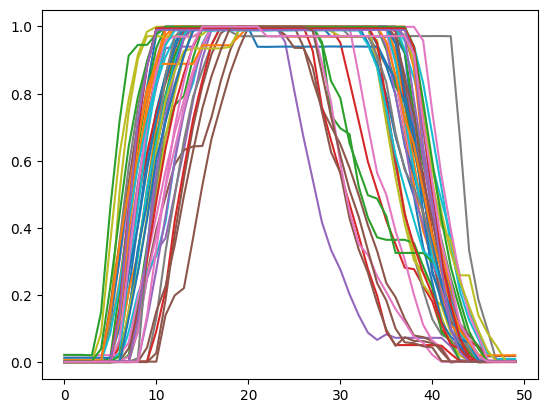

In [15]:
plt.plot(ALT) ;

## Calcul de l'erreur de reconstruction.

In [16]:
res = pd.DataFrame([], columns = ["NB"])
for df in dsn1:
    x = df["ALTN[-]"]
    xr = x.values
    s = x.index
    t0 = s[0].value
    t1 = s[-1].value
    t = pd.to_datetime(np.linspace(t0,t1,N))
    col = df.index.name
    y = ALT[col]
    yr = np.interp(s,t,y)
    NB = len(xr)
    ERR_total = sum(np.abs(yr-xr))
    MAE_local = ERR_total/M
    ERR_MAX = np.max(np.abs(yr-xr))




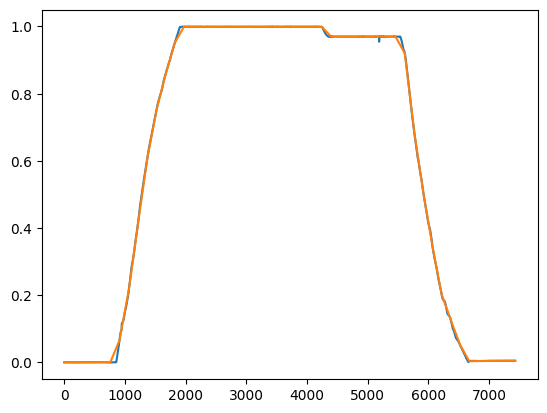

In [21]:
plt.plot(x.values)
plt.plot(yr)